In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

customers = pd.read_csv("https://drive.google.com/uc?id=1bu_--mo79VdUG9oin4ybfFGRUSXAe-WE")
products = pd.read_csv("https://drive.google.com/uc?id=1IKuDizVapw-hyktwfpoAoaGtHtTNHfd0")
transactions = pd.read_csv("https://drive.google.com/uc?id=1saEqdbBB-vuk2hxoAf4TzDEsykdKlzbF")


customers["SignupDate"] = pd.to_datetime(customers["SignupDate"])
transactions["TransactionDate"] = pd.to_datetime(transactions["TransactionDate"])

merged_data = transactions.merge(customers, on="CustomerID", how="left")
merged_data = merged_data.merge(products, on="ProductID", how="left")
merged_data["Year"] = merged_data["TransactionDate"].dt.year
merged_data["Month"] = merged_data["TransactionDate"].dt.month
merged_data["SignupYear"] = merged_data["SignupDate"].dt.year
merged_data["AverageOrderValue"] = merged_data["TotalValue"] / merged_data["Quantity"]

print("\nMerged Data Preview:")
print(merged_data.head())


Merged Data Preview:
  TransactionID CustomerID ProductID     TransactionDate  Quantity  \
0        T00001      C0199      P067 2024-08-25 12:38:23         1   
1        T00112      C0146      P067 2024-05-27 22:23:54         1   
2        T00166      C0127      P067 2024-04-25 07:38:55         1   
3        T00272      C0087      P067 2024-03-26 22:55:37         2   
4        T00363      C0070      P067 2024-03-21 15:10:10         3   

   TotalValue  Price_x     CustomerName         Region SignupDate  \
0      300.68   300.68   Andrea Jenkins         Europe 2022-12-03   
1      300.68   300.68  Brittany Harvey           Asia 2024-09-04   
2      300.68   300.68  Kathryn Stevens         Europe 2024-04-04   
3      601.36   300.68  Travis Campbell  South America 2024-04-11   
4      902.04   300.68    Timothy Perez         Europe 2022-03-15   

                       ProductName     Category  Price_y  Year  Month  \
0  ComfortLiving Bluetooth Speaker  Electronics   300.68  2024      8

In [2]:
from sklearn.cluster import KMeans
from sklearn.metrics import davies_bouldin_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics.pairwise import cosine_similarity

Number of Clusters: 2, Davies-Bouldin Index: 1.7239028326729164
Number of Clusters: 3, Davies-Bouldin Index: 1.4365700023509078
Number of Clusters: 4, Davies-Bouldin Index: 1.1714695644070179
Number of Clusters: 5, Davies-Bouldin Index: 1.1181164026965122
Number of Clusters: 6, Davies-Bouldin Index: 1.1028313846716247
Number of Clusters: 7, Davies-Bouldin Index: 1.0689030232273287
Number of Clusters: 8, Davies-Bouldin Index: 1.0003469357954293
Number of Clusters: 9, Davies-Bouldin Index: 0.9773571291863493
Number of Clusters: 10, Davies-Bouldin Index: 0.9059764977714977

Optimal Number of Clusters: 10, Best DB Index: 0.9059764977714977


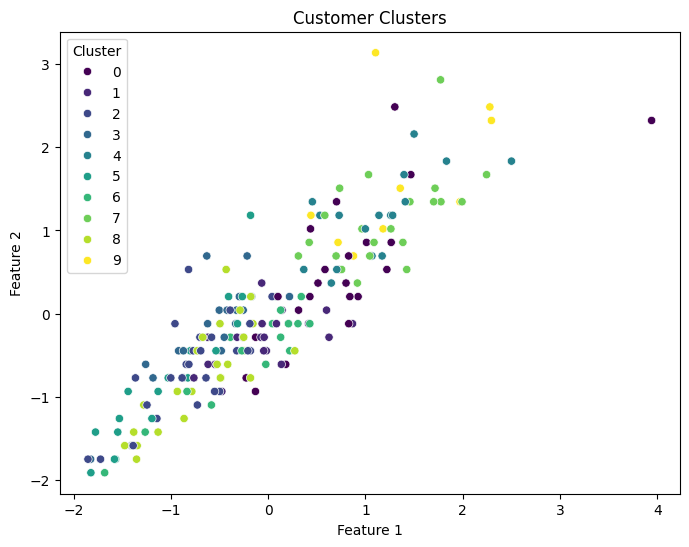


Clustering Results:
Optimal Number of Clusters: 10
Best DB Index: 0.9059764977714977
Clustered Data Saved to 'Customer_Clusters.csv'


In [3]:
# Task 3: Customer Segmentation / Clustering
# Prepare data for clustering
customer_cluster_data = merged_data.groupby("CustomerID").agg({
    "TotalValue": "sum",
    "Quantity": "sum",
    "AverageOrderValue": "mean",
    "Region": lambda x: x.mode()[0] if len(x.mode()) > 0 else None
}).reset_index()

# Convert categorical data into numeric
data_with_dummies = pd.get_dummies(customer_cluster_data, columns=["Region"], drop_first=True)

# Standardize features
scaler = StandardScaler()
scaled_data = scaler.fit_transform(data_with_dummies.iloc[:, 1:])

# Apply K-Means Clustering
best_db_index = float('inf')
optimal_k = 0

for k in range(2, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    clusters = kmeans.fit_predict(scaled_data)
    db_index = davies_bouldin_score(scaled_data, clusters)
    print(f"Number of Clusters: {k}, Davies-Bouldin Index: {db_index}")

    if db_index < best_db_index:
        best_db_index = db_index
        optimal_k = k

print(f"\nOptimal Number of Clusters: {optimal_k}, Best DB Index: {best_db_index}")

# Final Clustering with Optimal K
final_kmeans = KMeans(n_clusters=optimal_k, random_state=42)
customer_cluster_data['Cluster'] = final_kmeans.fit_predict(scaled_data)

# Visualize Clusters
plt.figure(figsize=(8, 6))
sns.scatterplot(
    x=scaled_data[:, 0],
    y=scaled_data[:, 1],
    hue=customer_cluster_data['Cluster'],
    palette='viridis',
    legend='full'
)
plt.title("Customer Clusters")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.legend(title="Cluster")
plt.show()

# Save clustering results
customer_cluster_data.to_csv("Customer_Clusters.csv", index=False)

# Report clustering metrics
print("\nClustering Results:")
print(f"Optimal Number of Clusters: {optimal_k}")
print(f"Best DB Index: {best_db_index}")
print("Clustered Data Saved to 'Customer_Clusters.csv'")


Number of Clusters Formed:
After analyzing the data, the optimal number of clusters determined using the Davies-Bouldin Index (DB Index) is 10. This result indicates that dividing the customers into 10 distinct groups provided the most effective segmentation based on the clustering algorithm.

DB Index Value:
The best Davies-Bouldin Index value achieved is 0.9059.
The DB Index is a measure of clustering quality, where lower values indicate better-defined and more distinct clusters. A DB Index below 1.0 is typically considered good, suggesting that the clusters are compact and well-separated.